In [1]:
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
import sys
import warnings
import logging
from pprint import pformat
import os

import numpy as np
import pandas as pd
from pmdarima.arima import ARIMA, auto_arima
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l1_l2
import dynamic_yaml
import yaml
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sys.path.append("/tf/correlation-coef-predict/ywt_library")
import data_generation
from data_generation import data_gen_cfg
from ywt_arima import arima_model, arima_err_logger_init
from stl_decompn import stl_decompn
from corr_property import calc_corr_ser_property

with open('../../config/data_config.yaml') as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

warnings.simplefilter("ignore")
logging.basicConfig(level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
logger_list = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
# print(logger_list)


# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E501
logging.debug(pformat(data_cfg, indent=1, width=100, compact=True))

time: 2.01 s (started: 2022-12-06 08:53:24 +00:00)


# Prepare data

## Data implement & output setting & testset setting

In [2]:

# setting of output files
save_corr_data = True
save_arima_resid_data = True
# data implement setting
data_implement = "SP500_20082017_CORR_SER_REG_CORR_MAT_HRCHY_11_CLUSTER"  # watch options by operate: print(data_cfg["DATASETS"].keys())
# test set setting
test_items_setting = "-test_test"  # -test_test|-test_all
# data split period setting, only suit for only settings of Korean paper
data_split_setting = "-data_sp_test2"
# lstm weight setting
lstm_weight_setting = "SP500_20082017_TEST_5000_EPOCH_KS_HYPER_LSTM"  # watch options by operate: print(data_cfg["LSTM_WEIGHT"].keys())

time: 567 µs (started: 2022-12-06 08:53:26 +00:00)


In [3]:
# data loading & implement setting
dataset_df = pd.read_csv(data_cfg["DATASETS"][data_implement]['FILE_PATH'])
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns)  # all data
train_set = data_cfg["DATASETS"][data_implement]['TRAIN_SET']
test_set = data_cfg['DATASETS'][data_implement]['TEST_SET'] if data_cfg['DATASETS'][data_implement].get('TEST_SET') else [p for p in all_set if p not in train_set]  # all data - train data
logging.info(f"===== len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)} =====")

# test items implement settings
items_implement = test_set if test_items_setting == "-test_test" else all_set
logging.info(f"===== len(test set): {len(items_implement)} =====")

lstm_weight_filepath = data_cfg["ARIMA_LSTM_LSTM_WEIGHT"][lstm_weight_setting]["FILE_PATH"]
lstm_weight_name = data_cfg["ARIMA_LSTM_LSTM_WEIGHT"][lstm_weight_setting]["LSTM_WEIGHT_NAME"]
logging.info(f"===== LSTM weight:{lstm_weight_name} =====")

# setting of name of output files and pictures title
output_file_name = data_cfg["DATASETS"][data_implement]['OUTPUT_FILE_NAME_BASIS'] + test_items_setting
fig_title = data_implement + test_items_setting + lstm_weight_name + data_split_setting
logging.info(f"===== file_name basis:{output_file_name}, fig_title basis:{fig_title} =====")
# display(dataset_df)
# display(test_set)

# output folder settings
corr_data_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-corr_data"
arima_result_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-arima_res"
corr_property_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}{lstm_weight_name}-corr_property"
res_dir = Path('./results/')

corr_data_dir.mkdir(parents=True, exist_ok=True)
arima_result_dir.mkdir(parents=True, exist_ok=True)
corr_property_dir.mkdir(parents=True, exist_ok=True)
res_dir.mkdir(parents=True, exist_ok=True)

INFO:root:===== len(train_set): 66, len(all_set): 97, len(test_set): 31 =====
INFO:root:===== len(test set): 31 =====
INFO:root:===== LSTM weight:-sp500_20082017_5000_epoch_kS_hyper_lstm =====
INFO:root:===== file_name basis:sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-test_test, fig_title basis:SP500_20082017_CORR_SER_REG_CORR_MAT_HRCHY_11_CLUSTER-test_test-sp500_20082017_5000_epoch_kS_hyper_lstm-data_sp_test2 =====


time: 27 ms (started: 2022-12-06 08:53:26 +00:00)


## Load or Create Correlation Data

In [4]:
data_length = int(len(dataset_df)/data_gen_cfg["CORR_WINDOW"])*data_gen_cfg["CORR_WINDOW"]
corr_ser_len_max = int((data_length-data_gen_cfg["CORR_WINDOW"])/data_gen_cfg["CORR_STRIDE"])
max_data_div_start_add = 0  # In the Korea paper, each pair has 5 corr_series(due to diversifing train data).
                            # BUT we only need to take one, so take 0 as arg.
corr_ind = []

# DEFAULT SETTING: data_gen_cfg["DATA_DIV_STRIDE"] == 20, data_gen_cfg["CORR_WINDOW"]==100, data_gen_cfg["CORR_STRIDE"]==100
data_end_init = corr_ser_len_max * data_gen_cfg["CORR_STRIDE"]
for i in range(0, max_data_div_start_add+1, data_gen_cfg["DATA_DIV_STRIDE"]):
    corr_ind.extend(list(range(data_gen_cfg["CORR_WINDOW"]-1+i, data_end_init+bool(i)*data_gen_cfg["CORR_STRIDE"], data_gen_cfg["CORR_STRIDE"])))  # only suit for settings of paper

train_df_path = corr_data_dir/f"{output_file_name}-corr_train.csv"
dev_df_path = corr_data_dir/f"{output_file_name}-corr_dev.csv"
test1_df_path = corr_data_dir/f"{output_file_name}-corr_test1.csv"
test2_df_path = corr_data_dir/f"{output_file_name}-corr_test2.csv"
all_corr_df_paths = dict(zip(["train_df", "dev_df", "test1_df", "test2_df"],
                             [train_df_path, dev_df_path, test1_df_path, test2_df_path]))
if all([df_path.exists() for df_path in all_corr_df_paths.values()]):
    corr_datasets = [pd.read_csv(df_path).set_index("items") for df_path in all_corr_df_paths.values()]
else:
    corr_datasets = data_generation.gen_train_data(items_implement, raw_data_df=dataset_df, corr_ser_len_max=corr_ser_len_max, corr_df_paths=all_corr_df_paths, corr_ind=corr_ind, max_data_div_start_add=max_data_div_start_add, save_file=save_corr_data)

time: 9.17 ms (started: 2022-12-06 08:53:26 +00:00)


In [5]:
if data_split_setting == "-data_sp_test2":
    corr_dataset = corr_datasets[3]
logging.info(f"{corr_datasets[0].shape, corr_datasets[1].shape, corr_datasets[2].shape, corr_datasets[3].shape}")
# display(corr_dataset.iloc[0,::])
display(corr_dataset.head())

INFO:root:((465, 21), (465, 21), (465, 21), (465, 21))


,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,2012-05-11,2012-10-03,2013-03-01,...,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04,2016-09-26,2017-02-17,2017-07-12
items,,,,,,,,,,,,,,,,,,,,,
DRI & HIG_0,0.079463,0.304255,0.694066,0.362742,0.101515,-0.288340,0.687424,0.932067,0.786331,-0.685787,...,0.911712,0.564707,0.184837,0.761711,0.765829,0.155122,0.645082,0.577681,0.950803,0.600848
DRI & C_0,0.499580,0.151627,0.867576,0.309355,0.205451,-0.482884,0.688029,0.846123,0.832022,-0.737291,...,0.408745,0.577081,0.275907,-0.212134,0.423603,0.332430,-0.076648,-0.203725,0.931620,0.574015
DRI & ARE_0,0.107241,0.288204,0.783843,0.696546,-0.214517,0.784087,0.586312,0.738360,0.656293,-0.197286,...,0.230982,-0.577903,-0.654209,0.919261,-0.262261,0.028063,0.493890,-0.692041,0.657122,0.597885
DRI & MAT_0,0.001655,-0.163247,0.951226,0.436216,0.603795,0.745472,0.080286,0.936568,0.731164,-0.477022,...,0.832257,0.770523,-0.279889,-0.627284,-0.141355,-0.567847,0.609124,-0.435047,-0.404511,-0.831310
DRI & NBL_0,0.357367,0.282873,0.083450,0.630975,0.416892,0.052463,0.537145,0.091311,0.858588,-0.745511,...,0.792446,0.087182,-0.286283,-0.752917,-0.485836,-0.422365,0.426590,0.442885,0.738048,-0.852257


time: 14.3 ms (started: 2022-12-06 08:53:26 +00:00)


# ARIMA model

In [6]:
arima_result_path_basis = arima_result_dir/f'{output_file_name}.csv'
arima_result_types = ["-arima_output", "-arima_resid", "-arima_model_info"]
arima_result_paths = []
arima_err_logger_init(Path(os.path.abspath(''))/f"results")

for arima_result_type in arima_result_types:
    arima_result_paths.append(arima_result_dir/f'{output_file_name}{arima_result_type}{data_split_setting}.csv')

if all([df_path.exists() for df_path in arima_result_paths]):
    arima_output_df, arima_resid_df, arima_model_info_df = [pd.read_csv(arima_result_path, index_col="items") for arima_result_path in arima_result_paths]
else:
    arima_output_df, arima_resid_df, arima_model_info_df = arima_model(corr_dataset, arima_result_path_basis=arima_result_path_basis, data_split_setting=data_split_setting, save_file=save_arima_resid_data)

time: 7.11 ms (started: 2022-12-06 08:53:26 +00:00)


# LSTM

In [7]:
def double_tanh(x):
    return (tf.math.tanh(x) * 2)


lstm_model = load_model(lstm_weight_filepath, custom_objects={'double_tanh':double_tanh})
lstm_model.summary()

2022-12-06 08:53:27.802507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:53:27.805542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:53:27.805679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 08:53:27.806282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "lstm1_fc1-kS_hyper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm-kS_hyper (LSTM)        (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
time: 1.5 s (started: 2022-12-06 08:53:26 +00:00)


# Hybrid model

In [8]:
lstm_input = arima_resid_df.iloc[::,:-1].values.reshape(-1, 20, 1)
lstm_pred = lstm_model.predict(lstm_input)
lstm_pred = pd.DataFrame(lstm_pred, index=arima_resid_df.index, columns=["lstm_pred"])

2022-12-06 08:53:29.145826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


15/15 [==============================] - 1s 1ms/step
time: 1.1 s (started: 2022-12-06 08:53:28 +00:00)


## Results post-processing

In [9]:
def res_df_postprocess(merge_dfs: list) -> "pd.DataFrame":

    tmp_df = pd.DataFrame(columns=["items"])
    for merge_df in merge_dfs:
        tmp_df = pd.merge(tmp_df, merge_df, on="items", how='outer')
    else:
        results_df = tmp_df.reset_index(drop=True)

    results_df["hybrid_model_pred"] =  results_df["arima_pred"] + results_df["lstm_pred"]
    results_df["error"] = results_df["ground_truth"] - results_df["hybrid_model_pred"]
    results_df["absolute_err"] = results_df["error"].abs()
    results_df['arima_pred_dir'] = np.sign(results_df['ground_truth'] * results_df['arima_pred'])
    results_df['arima_err'] = results_df['ground_truth'] - results_df['arima_pred']
    results_df["lstm_compensation_dir"] = np.sign(results_df['arima_err']) * np.sign(results_df['lstm_pred'])
    quantile_mask = np.logical_and(results_df['error'] < np.quantile(results_df['error'], 0.75), results_df['error'] > np.quantile(results_df['error'], 0.25)).tolist()
    results_df['high_pred_performance'] = quantile_mask
    results_df['items[0]'] = results_df.apply(lambda row:row['items'].split(" & ")[0], axis=1)
    results_df['items[1]'] = results_df.apply(lambda row:row['items'].split(" & ")[1][:-2], axis=1)
    results_df = results_df.set_index("items")

    return results_df


# stl_decompn(corr_datasets[0].iloc[0,::], overview=True)
corr_property_df_path = corr_property_dir/f"{output_file_name}{lstm_weight_name}{data_split_setting}-corr_series_property.csv"

if corr_property_df_path.exists():
    corr_property_df = pd.read_csv(corr_property_df_path)
else:
    corr_property_df = calc_corr_ser_property(corr_dataset=corr_dataset, corr_property_df_path=corr_property_df_path)

ground_truth = corr_dataset.iloc[::, -1]
ground_truth.name = "ground_truth"
arima_pred = arima_output_df.iloc[::, -1]
arima_pred.name = "arima_pred"
merge_dfs = [arima_model_info_df, corr_property_df, arima_pred, lstm_pred, ground_truth]

res_df = res_df_postprocess(merge_dfs)
res_df.to_csv(res_dir/f"{output_file_name}{lstm_weight_name}{data_split_setting}-res.csv")

time: 26.8 ms (started: 2022-12-06 08:53:29 +00:00)


# Display results

In [10]:
res_df = pd.read_csv(res_dir/f"{output_file_name}{lstm_weight_name}{data_split_setting}-res.csv", index_col=["items"])
logging.info(f"""
                 mse :{(res_df['error']**2).mean()},
                 std of square_err :{(res_df['error']**2).std()},
                 rmse :{np.sqrt((res_df['error']**2).mean())},
                 mae : {res_df['absolute_err'].mean()},
                 std of abs_err: {res_df['absolute_err'].std()},
                 sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['hybrid_model_pred'])}
              """)
logging.info("-"*50)
logging.info(f"""
                 mse of ARIMA :{(res_df['arima_err']**2).mean()},
                 std of square_err ARIMA :{(res_df['arima_err']**2).std()},
                 rmse of ARIMA :{np.sqrt((res_df['arima_err']**2).mean())},
                 sklearn mse of ARIMA: {mean_squared_error(res_df['ground_truth'], res_df['arima_pred'])}
              """)

INFO:root:
                 mse :0.3990859550197408,
                 std of square_err :0.4823380236530969,
                 rmse :0.6317325027412638,
                 mae : 0.5171334294674369,
                 std of abs_err: 0.36323920345914307,
                 sklearn mse: 0.3990859550197408
              
INFO:root:--------------------------------------------------
INFO:root:mse of ARIMA :0.4214136739402244,
                 std of square_err ARIMA :0.5152802646293319,
                 rmse of ARIMA :0.6491638267342261,
                 sklearn mse of ARIMA: 0.42141367394022444
              


time: 7.56 ms (started: 2022-12-06 08:53:29 +00:00)


In [11]:
def plot_exploration(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=7, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s5 = axes[2, 1]
    s5.set_title("LSTM_compensation_dir count groupby ARIMA_pred_dir")
    df_gb = target_df.groupby(['arima_pred_dir', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s5)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude in last period group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    s12 = axes[6,0]
    s12.set_title("LSTM_compensation_dir pie with wrong ARIMA_pred_dir")
    df_gb.loc[df_gb.index==-1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s12)
    s13 = axes[6,1]
    s13.set_title("LSTM_compensation_dir pie with correct ARIMA_pred_dir")
    df_gb.loc[df_gb.index==1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s13)

    fig.suptitle(f"{title}_basic_exploration")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_{title}.png")
    plt.show()
    plt.close()


def plot_exploration_pred_perform(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s1 = axes[0, 0]
    s1.set_title("LSTM_compensation_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s1)
    s2 = axes[0, 1]
    s2.set_title("ARIMA_model prediction magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["arima_pred"], ax=s2)
    s3 = axes[1, 0]
    s3.set_title("LSTM compensation magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["lstm_pred"], ax=s3)
    s4 = axes[1, 1]
    s4.set_title("Correlation magnitude in last period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["ground_truth"], ax=s4)
    s5 = axes[2, 0]
    s5.set_title("Correlation series mean groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_mean"], ax=s5)
    s6 = axes[2, 1]
    s6.set_title("Correlation series std groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_std"], ax=s6)
    s7 = axes[3, 0]
    s7.set_title("Correlation series stl_period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_period"], ax=s7)
    s8 = axes[3, 1]
    s8.set_title("Correlation series stl_residual group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_resid"], ax=s8)
    s9 = axes[4, 0]
    s9.set_title("Correlation series stl_trend_std group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_std"], ax=s9)
    s10 = axes[4, 1]
    s10.set_title("Correlation series stl_trend_coef group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_coef"], ax=s10)
    s11 = axes[5, 0]
    s11.set_title("ARIMA_pred_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'arima_pred_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s11)

    fig.suptitle(F"{title}_groupby prediction")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_groupby_pred_perform_{title}.png")
    plt.show()
    plt.close()


def plot_stock_freq(target_df: pd.core.frame.DataFrame, title: str) -> None:
    stocks_show_freq = target_df.loc[target_df['high_pred_performance'] == True, ['items[0]','items[1]']].stack().value_counts().to_dict()
    plt.figure(figsize=(80, 10), dpi=100)
    plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
    plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)
    plt.title(F"{title}_items appearence frequence")
    plt.savefig(f"./results/items_appearence_frequence_{title}.png")
    plt.show()
    plt.close()

time: 3.14 ms (started: 2022-12-06 08:53:29 +00:00)


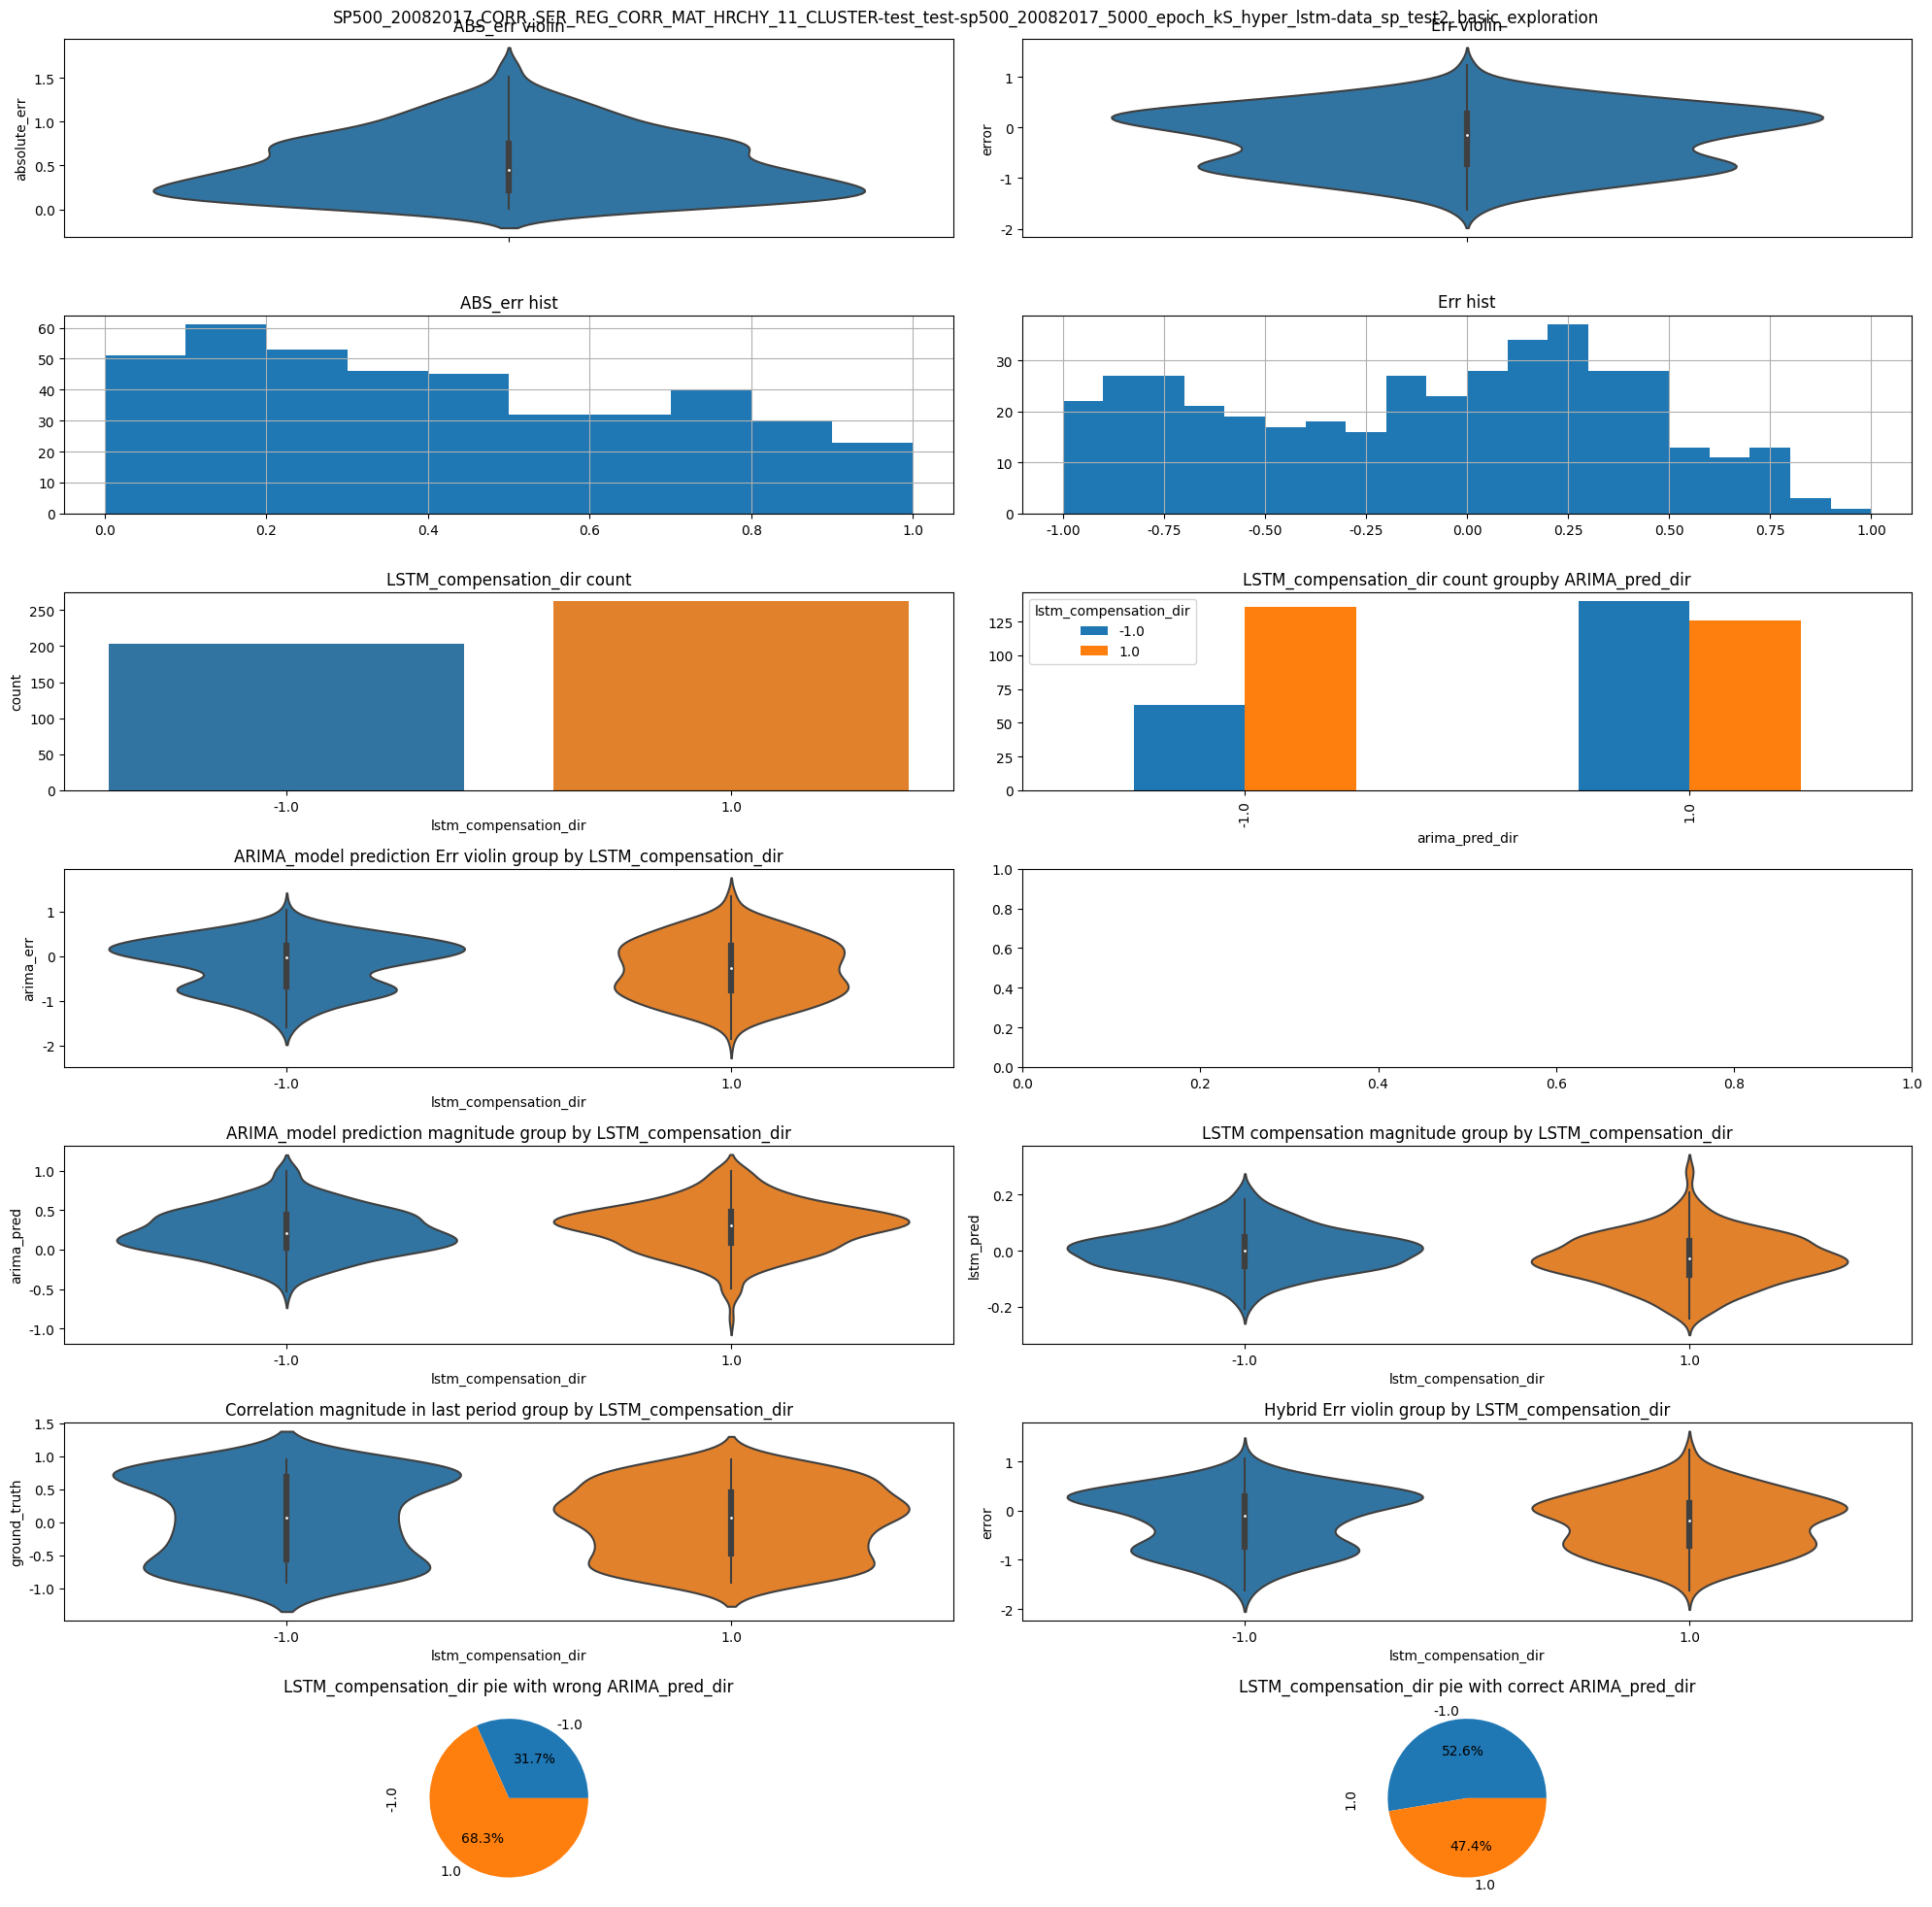

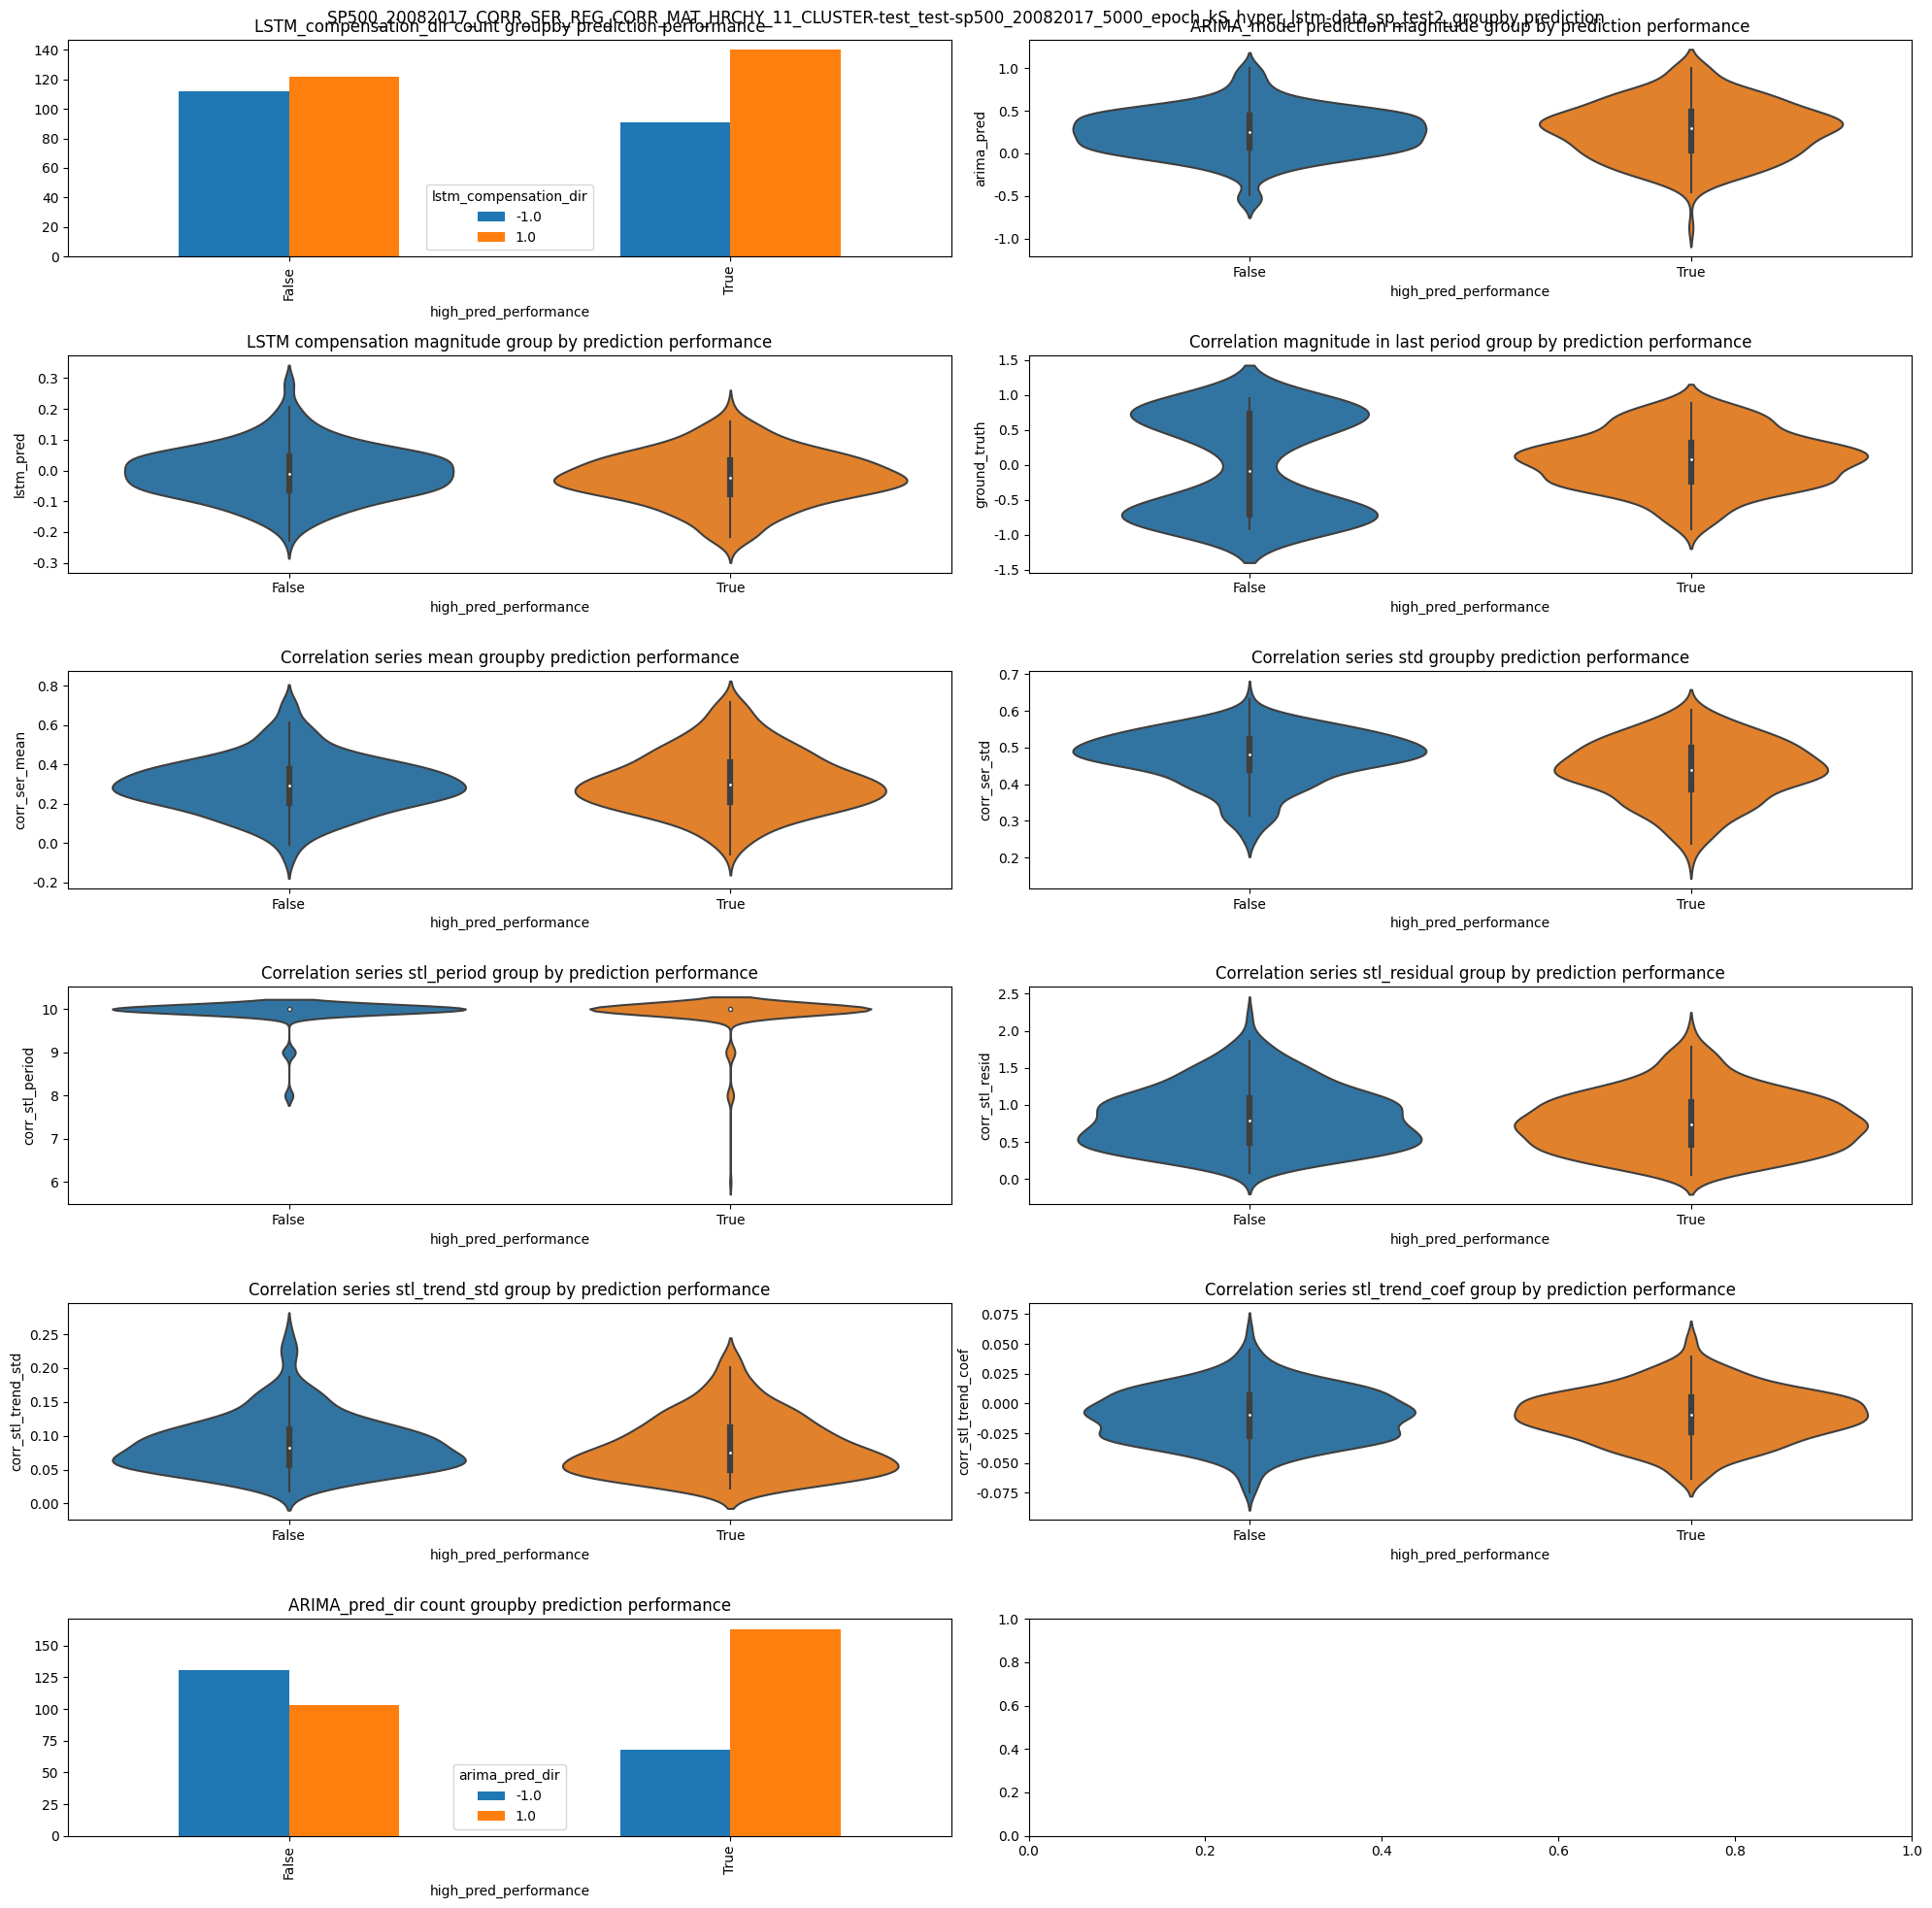

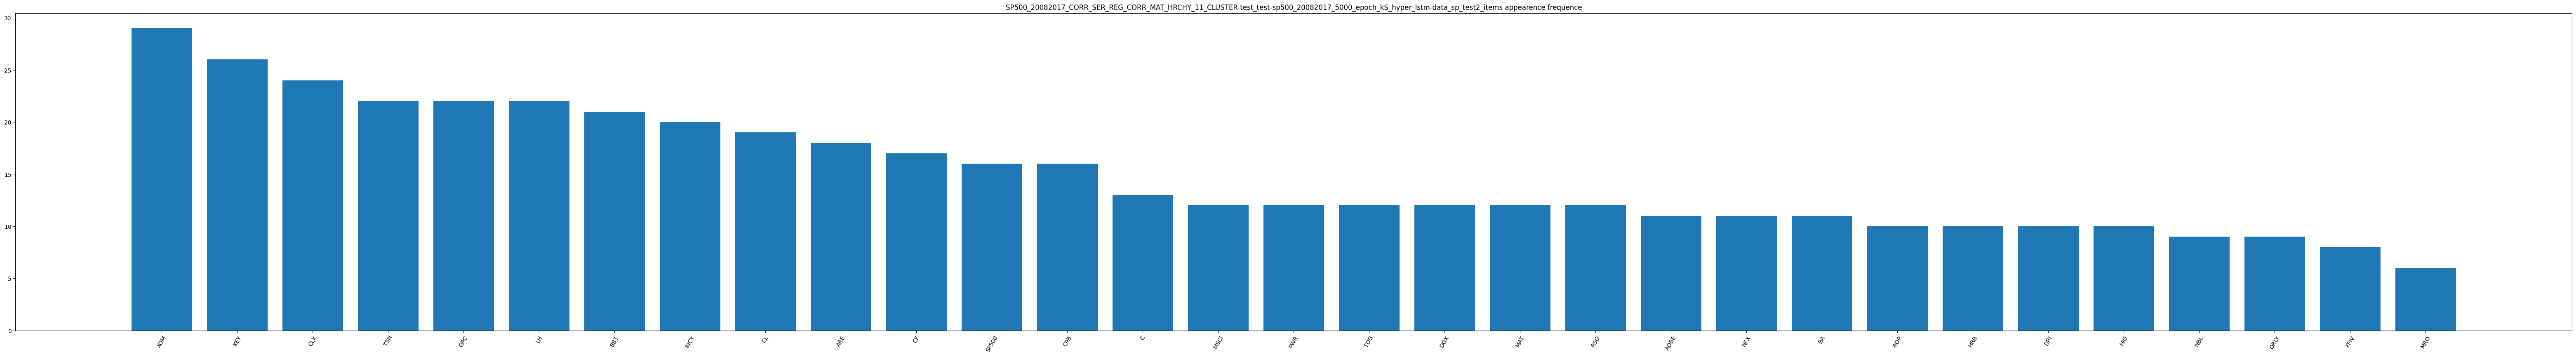

time: 4.1 s (started: 2022-12-06 08:53:29 +00:00)


In [12]:
plot_exploration(res_df, fig_title)
plot_exploration_pred_perform(res_df, fig_title)
plot_stock_freq(res_df, fig_title)